<a href="https://colab.research.google.com/github/MichalWilk45/MichalWilk45/blob/main/DS2_Image_Processing_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [5]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/dataAlienPredator/data/train',
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/dataAlienPredator/data/validation',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 581 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [7]:
conv_base = ResNet50(include_top=False,
                     weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 6s 0us/step


In [8]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [9]:
history = model.fit_generator(
    generator=train_generator,
    epochs=3,
    validation_data=validation_generator)

<ipython-input-9-cc74a4b51e11>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
19/19 [==============================] - 606s 32s/step - loss: 0.6946 - accuracy: 0.7194 - val_loss: 0.2702 - val_accuracy: 0.8800
Epoch 2/3
19/19 [==============================] - 10s 539ms/step - loss: 0.1742 - accuracy: 0.9294 - val_loss: 0.2025 - val_accuracy: 0.9050
Epoch 3/3
19/19 [==============================] - 9s 472ms/step - loss: 0.1067 - accuracy: 0.9604 - val_loss: 0.1501 - val_accuracy: 0.9450


In [10]:
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator)

Epoch 1/3
19/19 [==============================] - 10s 486ms/step - loss: 0.0855 - accuracy: 0.9656 - val_loss: 0.1522 - val_accuracy: 0.9300
Epoch 2/3
19/19 [==============================] - 10s 537ms/step - loss: 0.0585 - accuracy: 0.9811 - val_loss: 0.1291 - val_accuracy: 0.9300
Epoch 3/3
19/19 [==============================] - 10s 529ms/step - loss: 0.0439 - accuracy: 0.9828 - val_loss: 0.1429 - val_accuracy: 0.9250


In [11]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Wed Apr 19 18:22:07 2023
Driver Version                            : 525.85.12
CUDA Version                              : 12.0

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla T4
    Product Brand                         : NVIDIA
    Product Architecture                  : Turing
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 1564221009180
    GPU UUID             

In [12]:
# architecture and weights to HDF5
model.save('models/keras/model.h5')

# architecture to JSON, weights to HDF5
model.save_weights('models/keras/weights.h5')
with open('models/keras/architecture.json', 'w') as f:
    f.write(model.to_json())

In [13]:
# architecture and weights from HDF5
model = load_model('models/keras/model.h5')

# architecture from JSON, weights from HDF5
with open('models/keras/architecture.json') as f:
    model = model_from_json(f.read())
model.load_weights('models/keras/weights.h5')

In [15]:
validation_img_paths = ["/content/gdrive/MyDrive/dataAlienPredator/data/validation/alien/11.jpg",
                        "/content/gdrive/MyDrive/dataAlienPredator/data/validation/alien/22.jpg",
                        "/content/gdrive/MyDrive/dataAlienPredator/data/validation/predator/34.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [16]:
validation_batch = np.stack([preprocess_input(np.array(img.resize((224, 224))))
                             for img in img_list])

pred_probs = model.predict(validation_batch)

1/1 [==============================] - 3s 3s/step


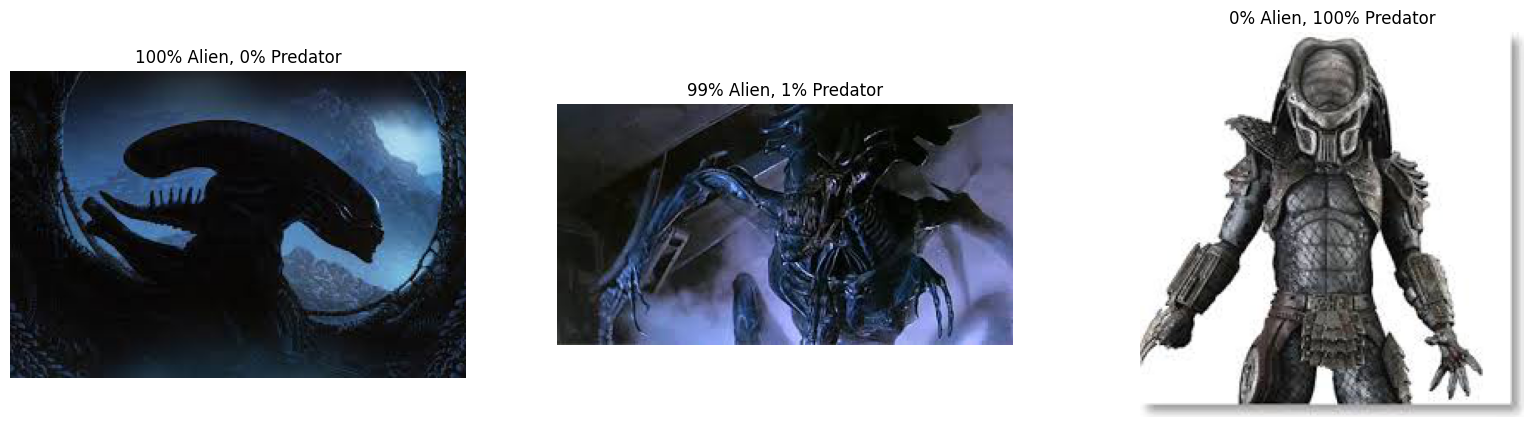

In [17]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)